### 1.) Import the necessary modules.

In [1]:
# If importing the os and then setting visible devices throws any
# errors, just remove these two os lines.
import os
import sys
os.environ["CUDA_VISIBLE_DEVICES"] = "6"
%matplotlib notebook
import numpy as np
import pandas as pd
import keras
import importlib
from keras.layers import Dense
from keras.models import Sequential
from tracker import extractor, utils, metrics, visuals

Using Theano backend.


### 2.) Load in and prepare a frame of data.

In [2]:
importlib.reload(extractor)
your_frame_filepath = "data/sets/ACTS-SMALL-NOT-PREPARED.gz"
your_frame = pd.read_csv(your_frame_filepath)

print("Preparing the frame. This may take a little while.")
prepared_frame = extractor.prepare_frame(
    frame   = your_frame,
    n_tracks = 10,   # Maximum number of regular tracks per event.
    n_rows  = 50,  # Maximum number of regular hits plus number of noisy hits per event.
    n_noise = 0,   # Number of noisy hits to add to each event.
)
prepared_frame = prepared_frame.sort_values(["event_id", "cluster_id", "r"])

print("Saving the frame. This may take a little while.")
save_filepath = "data/sets/ACTS-SMALL-PREPARED.gz"
prepared_frame.to_csv(save_filepath, compression="gzip")

print("All done.")
prepared_frame.head()

Preparing the frame. This may take a little while.
Saving the frame. This may take a little while.
All done.


,Unnamed: 0,cluster_id,event_id,noise,padding,phi,r,z
10,10.0,0.0,0.0,0.0,0.0,0.285327,31.959895,42.425
11,11.0,0.0,0.0,0.0,0.0,0.278982,71.842967,126.671
12,12.0,0.0,0.0,0.0,0.0,0.272315,115.818695,217.933
13,13.0,0.0,0.0,0.0,0.0,0.263837,171.809967,331.990
4,4.0,1.0,0.0,0.0,0.0,0.367411,31.959895,-121.959


### 3.) Load in prepared training and testing data and get a list of events

In [5]:
filepath_to_prepared_train_frame = "data/sets/ACTS-SMALL-PREPARED.gz"
filepath_to_prepared_test_frame  = "data/sets/ACTS-SMALL-PREPARED.gz"

print("Loading in the frame. This may take a little while.")
train_frame = pd.read_csv(filepath_to_prepared_train_frame)
test_frame  = pd.read_csv(filepath_to_prepared_test_frame)
train = utils.list_of_groups(train_frame, group="event_id")
test  = utils.list_of_groups(test_frame,  group="event_id")

print("Train is list of {0} events ({1} bytes).".format(len(train), sys.getsizeof(train)))
print("Test  is list of {0} events ({1} bytes).".format(len(test),  sys.getsizeof(test)))

if (not utils.is_prepared(train_frame)) or (not utils.is_prepared(test_frame)):
    print("Warning: frame is not prepared.")
    print("Look at the prepare_frame() function in tracker/extractor.py")
else:
    del train_frame # To save on memory space.
    del test_frame  # To save on memory space.

Loading in the frame. This may take a little while.
Train is list of 19 events (264 bytes).
Test  is list of 19 events (264 bytes).


### 4.) Specify how input is sorted before being put into the model.

In [6]:
# Sort by order[0] first. Then by order[1]. Finally, by order[2].
order = ["phi", "r", "z"]

### 5.) Show an example of the data that was loaded in.

Train 0
Number of Hits: 35
Number of Tracks: 10


<IPython.core.display.Javascript object>


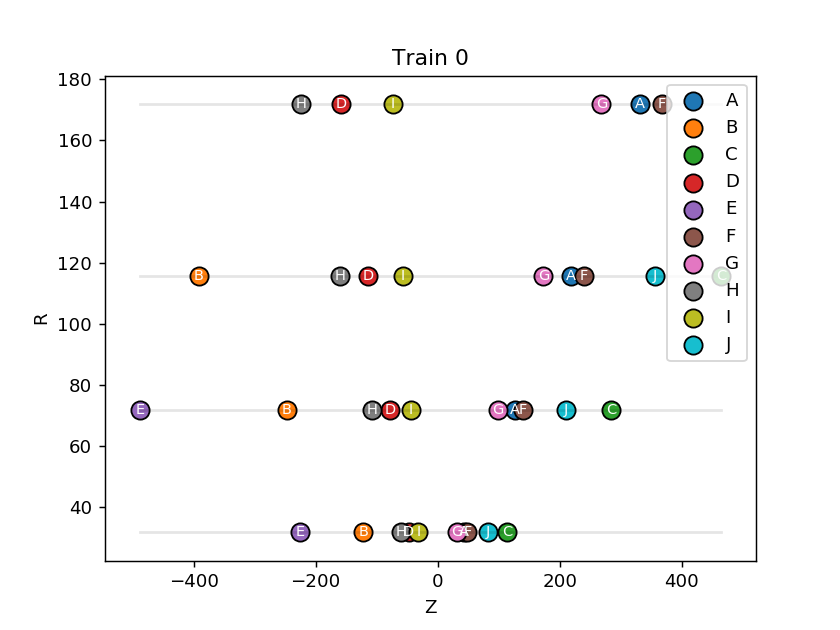

<IPython.core.display.Javascript object>


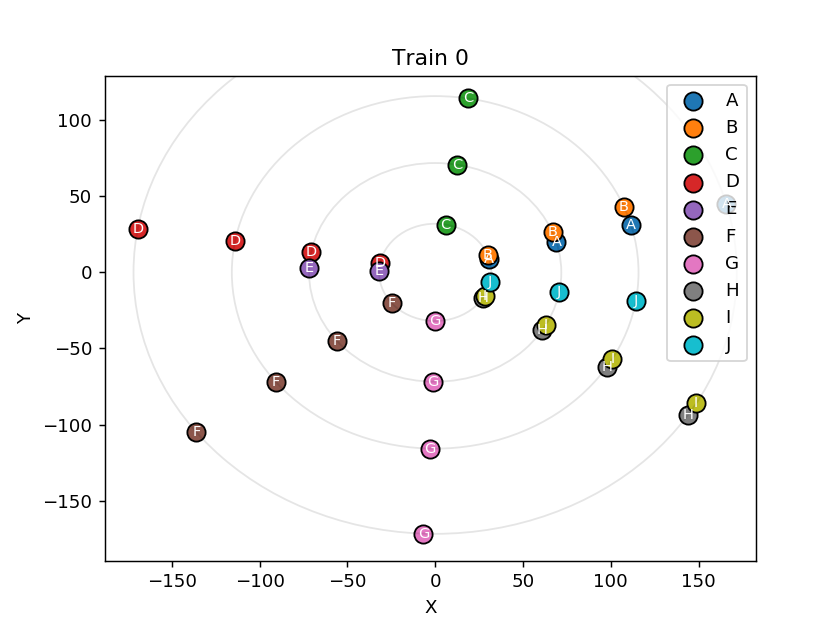

In [7]:
importlib.reload(visuals)
n = np.random.randint(len(train))
print("Train {}".format(n))
print("Number of Hits: {}".format(metrics.number_of_hits(train[n])))
print("Number of Tracks: {}".format(metrics.number_of_tracks(train[n])))
visuals.Plot2D(train[n], order).plot(mode="zr", title="Train {}".format(n))
visuals.Plot2D(train[n], order).plot(mode="xy", title="Train {}".format(n))

In [8]:
visuals.display(train[n], order)

,phi,r,z,A,B,C,D,E,F,G,H,I,J,K,padding
0,0.263837,171.809967,331.9900,1,,,,,,,,,,,
1,0.272315,115.818695,217.9330,1,,,,,,,,,,,
2,0.278982,71.842967,126.6710,1,,,,,,,,,,,
3,0.285327,31.959895,42.4250,1,,,,,,,,,,,
4,0.367411,31.959895,-121.9590,,1,,,,,,,,,,
5,0.374021,71.842967,-247.6810,,1,,,,,,,,,,
6,0.381647,115.818695,-391.1830,,1,,,,,,,,,,
7,1.383301,31.959895,113.5220,,,1,,,,,,,,,
8,1.394936,71.842967,284.6220,,,1,,,,,,,,,
9,1.407345,115.818695,464.8720,,,1,,,,,,,,,


### 6.) Create a model.

In [9]:
modelpath    = "where_my_model_will_be_stored.h5"
input_shape  = (50, 3)  # Shape is (Max number of rows, 3).
n_categories = 10 + 2  # Number of categories. Includes noise & padding categories.
optimizer    = keras.optimizers.RMSprop(lr=0.001)
histories    = []  # Where training history is stored.

In [ ]:
# If you want to load a model, run this cell.
# Otherwise, do not run this cell.
model = keras.models.load_model(modelpath)

In [11]:
# This model is very simple. It is not complex enough to assign hits to tracks well.
model = Sequential()

model.add(Dense(units=256, input_shape=input_shape))
model.add(Dense(units=n_categories, kernel_initializer="uniform", activation="softmax"))

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50, 256)           1024      
_________________________________________________________________
dense_2 (Dense)              (None, 50, 12)            3084      
Total params: 4,108.0
Trainable params: 4,108
Non-trainable params: 0.0
_________________________________________________________________


### 7.) Fit the model with the training data.

In [12]:
epochs     = 50
batch_size = 10
histories.append(model.fit_generator(
    extractor.input_output_generator(train, batch_size, order),
    steps_per_epoch=len(train) // batch_size,
    epochs=epochs,
#     verbose=1,
#     validation_data=extractor.input_output_generator(test, batch_size, order),
#     validation_steps=len(test) // batch_size,
#     callbacks=[
#         keras.callbacks.ModelCheckpoint(
#             filepath=modelpath,
#             save_best_only=True,
#             verbose=0,),
#         keras.callbacks.EarlyStopping(patience=10, verbose=1),
#         keras.callbacks.ReduceLROnPlateau(patience=5, verbose=1)]
))

Epoch 1/50
1/1 [==============================] - 0s - loss: 6.9096 - acc: 0.0400
Epoch 2/50
1/1 [==============================] - 0s - loss: 6.1101 - acc: 0.5022
Epoch 3/50
1/1 [==============================] - 0s - loss: 6.8278 - acc: 0.4760
Epoch 4/50
1/1 [==============================] - 0s - loss: 6.8269 - acc: 0.5222
Epoch 5/50
1/1 [==============================] - 0s - loss: 7.3965 - acc: 0.4400
Epoch 6/50
1/1 [==============================] - 0s - loss: 4.7421 - acc: 0.5689
Epoch 7/50
1/1 [==============================] - 0s - loss: 6.1512 - acc: 0.4400
Epoch 8/50
1/1 [==============================] - 0s - loss: 5.5260 - acc: 0.5422
Epoch 9/50
1/1 [==============================] - 0s - loss: 5.3100 - acc: 0.5120
Epoch 10/50
1/1 [==============================] - 0s - loss: 5.2416 - acc: 0.4644
Epoch 11/50
1/1 [==============================] - 0s - loss: 5.3114 - acc: 0.4660
Epoch 12/50
1/1 [==============================] - 0s - loss: 4.4564 - acc: 0.5489
Epoch 13/50
1

### 8.) Use some metrics to get general information about the trained model.

In [13]:
test.sort(key=lambda x: x.iloc[0]["event_id"])
guesses = model.predict(extractor.extract_input(test, order))

In [14]:
hits_correct     = metrics.percent_of_hits_assigned_correctly(test, guesses=guesses, order=order)
tracks_correct   = metrics.percent_of_tracks_assigned_correctly(test, guesses=guesses, order=order, percent=1.0)
n_tracks_correct = metrics.percent_of_events_with_correct_number_of_tracks(test, guesses=guesses, order=order)
print("Percent of hits assigned correctly: {}%".format(hits_correct * 100))
print("Percent of tracks assigned correctly: {}%".format(tracks_correct * 100))
print("Percent of events with the correct number of tracks: {}%".format(n_tracks_correct * 100))

Percent of hits assigned correctly: 10.458715596330276%
Percent of tracks assigned correctly: 6.976744186046512%
Percent of events with the correct number of tracks: 10.526315789473683%


### 9.) Graph a model's prediction.

Percent of hits assigned correctly: 12.5%
Percent of tracks assigned correctly: 10.0%


<IPython.core.display.Javascript object>


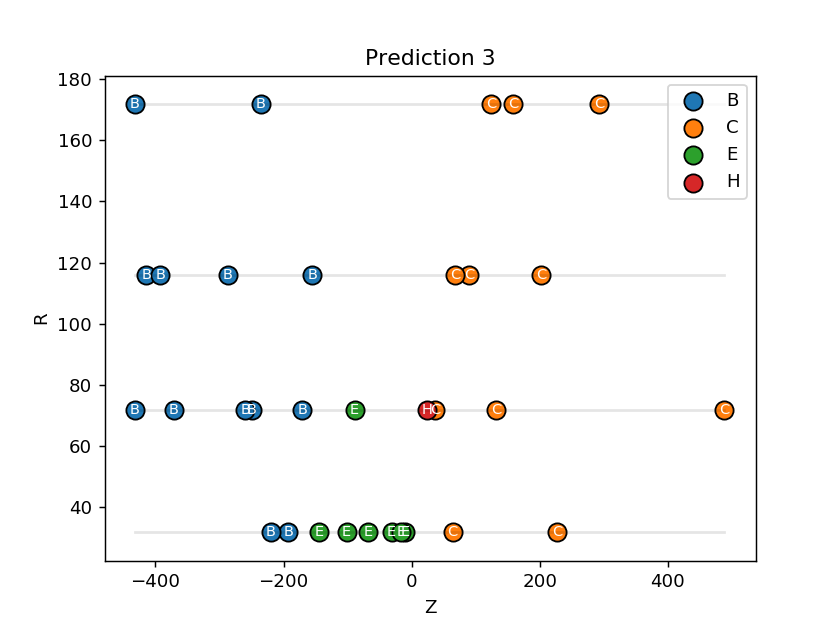

<IPython.core.display.Javascript object>


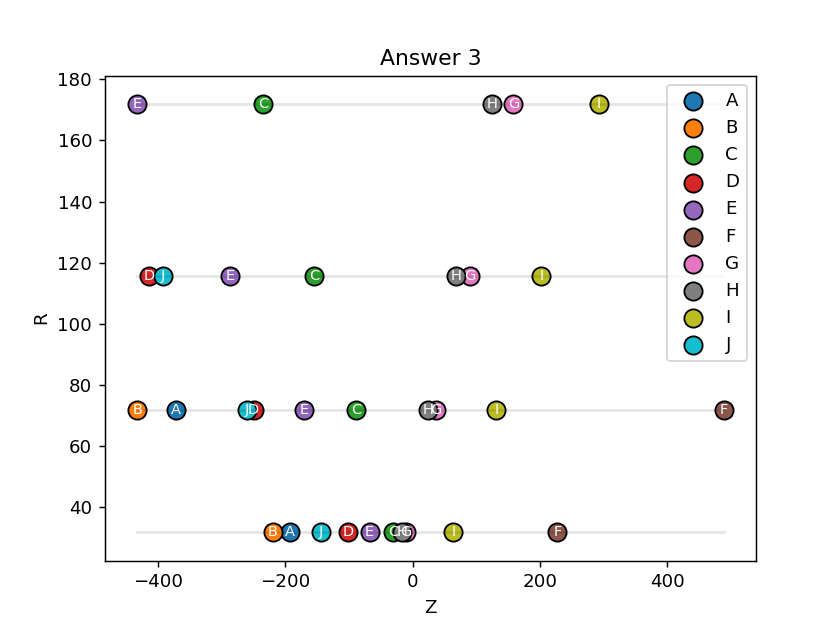

<IPython.core.display.Javascript object>


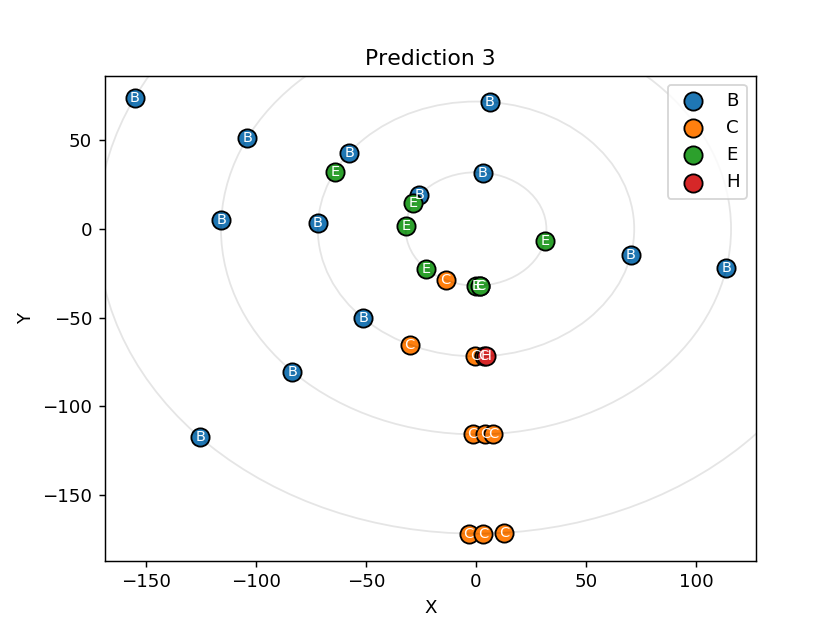

<IPython.core.display.Javascript object>


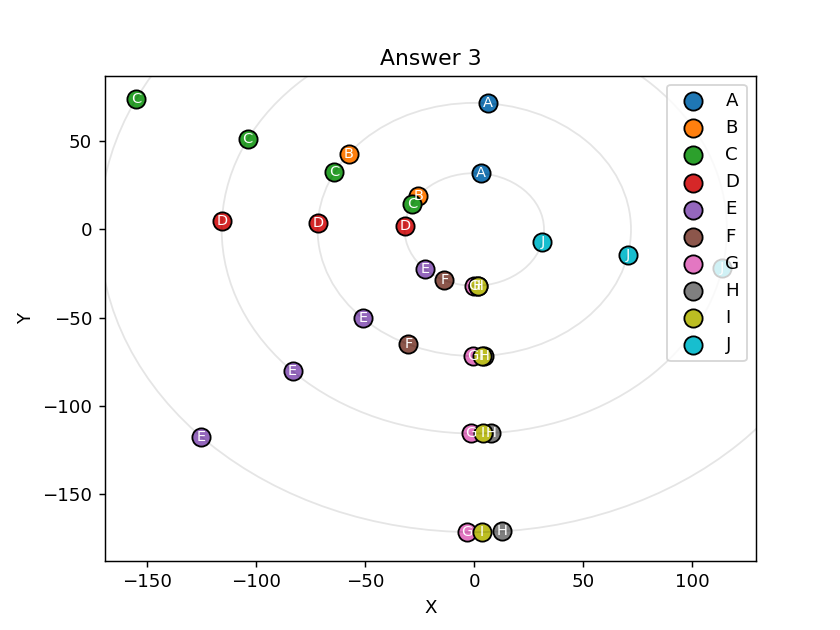

In [15]:
n  = 3  # The event number.
print("Percent of hits assigned correctly: {}%".format(
    metrics.percent_of_hits_assigned_correctly(test[n], guesses[n], order) * 100))
print("Percent of tracks assigned correctly: {}%".format(
    metrics.percent_of_tracks_assigned_correctly(test[n], guesses[n], order) * 100))
_ = visuals.Plot2D(test[n], order, guesses[n]).plot(mode="zr", title="Prediction {}".format(n))
_ = visuals.Plot2D(test[n], order).plot(mode="zr", title="Answer {}".format(n))
_ = visuals.Plot2D(test[n], order, guesses[n]).plot(mode="xy", title="Prediction {}".format(n))
_ = visuals.Plot2D(test[n], order).plot(mode="xy", title="Answer {}".format(n))

### 10.) Display Number of Tracks vs. Discrete Accuracy.

<IPython.core.display.Javascript object>


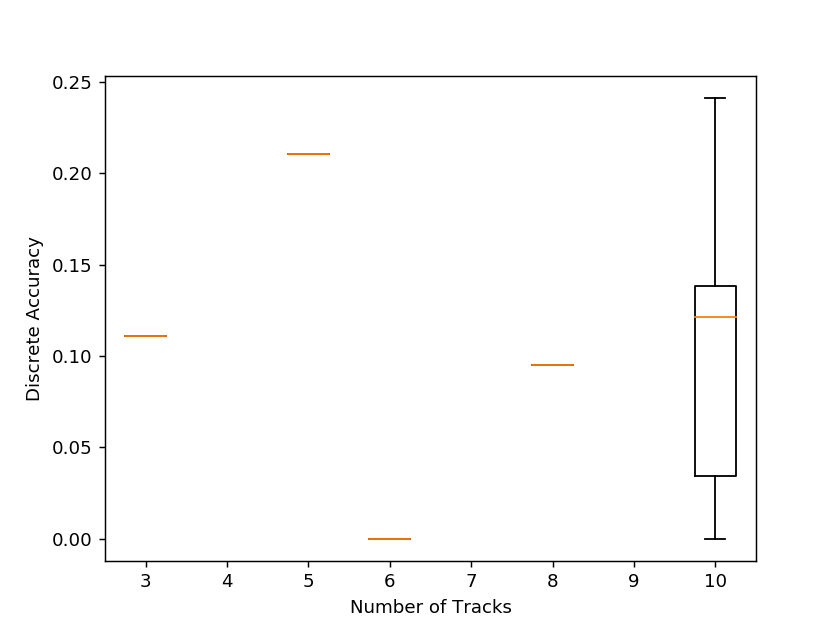

Wall time: 189 ms


In [16]:
%%time
n_tracks, accuracy = metrics.accuracy_vs_tracks(test, guesses, order)
r = range(n_tracks.min(), n_tracks.max() + 1)
boxes = [[] for _ in r]
for i in range(len(n_tracks)):
    boxes[n_tracks[i] - n_tracks.min()].append(accuracy[i])
visuals.boxplot(boxes, "", "Number of Tracks", "Discrete Accuracy", xticks=list(r))